In [1]:
import warnings

from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np

from logspectra.config import FFTConfig, Sampling, WaveDefinition
from logspectra.histogram import Interval, Histogram
from logspectra.interactive import interactive_example
from logspectra.plots import compare_histogram_and_interval, compare_spectra
from logspectra.spectrum import calculate_spectrum, calculate_cqt_spectrum, to_log_even_bands
from logspectra.wave import synthesize_wave

In [2]:
warnings.filterwarnings("ignore")

## Energy-preserving spectrum frequency transformation

The **Discrete Fourier Transform** (DFT) is a powerful tool for extracting frequency distribution information from audio samples. The transform decomposes a signal into components whose frequency ranges are linearly distributed from 0 up to the sampling frequency. However, human sound perception is not linear but logarithmic — the perceived difference between sounds depends not on the arithmetic difference between frequencies, but on their ratio.

Consequently, the DFT has the lowest sensitivity for low frequencies and the highest resolution for high frequencies. The size of the DFT is chosen to distinguish the low frequencies present in the collected samples. This resolution is $f_{\rm{sr}} / N$, where $f_{\rm{sr}}$ is the audio sampling rate and $N$ is the transform size.

In the following sections, we will seek a method to replace the standard spectrum with one having the property that the frequency distribution is **logarithmic**, or more precisely, the logarithms of the component ranges are equal.

We can treat the spectrum as a special case of a **histogram**.

## Histogram

Consider a histogram $H=\left\{(x_i)_{i=0}^n, (d_i)_{i=1}^n\right\}$, where for $i=1,\ldots,n$, the $x_i$ are bin edges:
$$x_0 < x_1 < \ldots < x_n,$$ and $d_i$ are the histogram values.

We seek a method to estimate histogram values for a different set of edges $(y_j)_{j=0}^m$. In other words, we are looking for an approximation $H'=\{(y_j)_{j=0}^m, (e_j)_{j=1}^m\}$ that linearly interpolates histogram $H$.

For any interval $I = [a, b]$, we can define an approximation derived from $H$ as a weighted sum of histogram values, where the weights are the proportions by which interval $I$ overlaps each bin.

#### Class definitions

**Interval**

```python
class Interval(NamedTuple):
    left: Float
    right: Float
```

**Histogram**

```python
@dataclass
class Histogram:
    edges: np.ndarray
    values: np.ndarray
```

In [3]:
# A simple histogram for [0, 10] interval
n = 10
edges = np.arange(n + 1)
values = edges[1:] * (n + 1 - edges[1:]) / n ** 2
histogram = Histogram(edges, values)

In [4]:
# Rebinning a single interval
interval = Interval(3.5, 5.25)  # covers entire #4, half of #3 and a quarter of #5
rebin = histogram.rebin(interval)  # single item histogram
value = rebin.values[0]
assert value == values[3] * 0.5 + values[4] * 1.0 + values[5] * 0.25

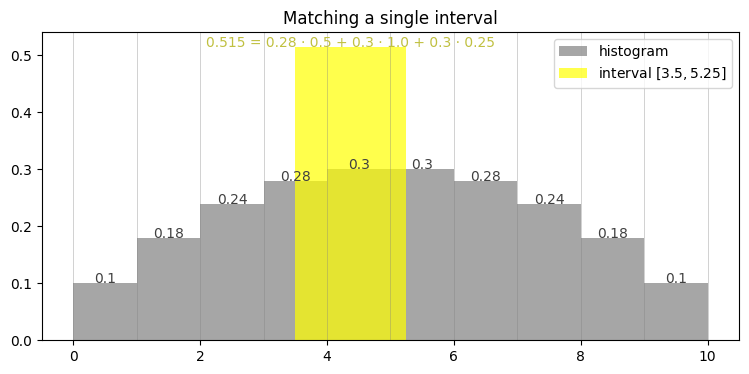

In [5]:
annotation = f"{value:2g} = {values[3]} ⋅ 0.5 + {values[4]} ⋅ 1.0 + {values[5]} ⋅ 0.25"
compare_histogram_and_interval(
    histogram,
    interval,
    annotation=annotation
)

The fraction of bin $X_i = [x_{i-1}, x_i]$ (for $i=1,\ldots,n$) that is covered by interval $I$ is given by the following measure: $$\mu_i(I) = \frac{\lambda\left(I \cap X_i\right)}{\lambda(X_i)}= \frac{\lambda\left(I \cap [x_{i-1}, x_i]\right)}{x_i - x_{i-1}},$$ where $\lambda$ is the standard Lebesgue measure on the real line. Thus: $$h_i(I) = h([a, b]) = d_i\cdot\mu_i(I)$$ Therefore, the approximation of histogram $H$ for interval $I$ is: $$h(I)=\sum_{i=1}^n h_i(I) = \sum_{i=1}^n d_i\cdot\mu_i(I)$$

Given a different set of edges $(y_j)_{j=1}^m$, for each interval $Y_j = [y_{j - 1}, y_j]$, we can compute the corresponding value $e_j=h(Y_j)=h\left([y_{j-1}, y_j]\right)$, for $j=1,\ldots,m$. Then our desired histogram $H'$ has the form: $$H' = \left\{(y_j)_{j=0}^m, h\left([y_{j-1}, y_j]\right)_{j=1}^m\right\}$$

This gives us a method for rebinning a histogram to an arbitrary scale, provided that the range of $H'$ covers $H$, i.e., $[x_0, x_n]\subseteq [y_0, y_m]$.

In the remainder, following the programming convention of zero-based indexing, we adopt: $$H=\left\{(x_i)_{i=0}^n, (d_i)_{i=0}^{n-1}\right\},$$ meaning we reindex the values $d$ to $i=0,\ldots,n-1$.

## Energy-preserving frequency transformation

Recall that the Discrete Fourier Transform of a sequence of values $(x_i)_{i=1}^N$ is a sequence of complex values:

$$\displaystyle X_{k}=\sum _{n=0}^{N-1}x_{n}\cdot e^{-i2\pi {\tfrac {k}{N}}n}$$

For the frequency transformation of the spectrum to be faithful, it must preserve the energy of the components, and in particular the energy of the entire signal. For complex-valued DFT coefficients, the energy of component $i$ is expressed as $|X_i|^2$, or $\frac{1}{N^2}|X_i|^2$ in normalized form (the *power spectrum*).

Therefore, it is important to remember that we should rebin the squares of the magnitudes of the DFT values, not the magnitudes themselves.

It is important to note that no finite set of bins can cover all positive frequencies on a logarithmic scale. This is because the logarithm of positive values approaches $-\infty$ as $x\rightarrow 0^{+}$ (approaching $0$ from the right), and an infinite interval cannot be divided by a finite number of bins of bounded length.

Therefore, we need a cutoff threshold for the lower frequencies. This is an operation that loses information, so it is important to choose a threshold below which frequencies are not significant.

In [6]:
# Sample definition
sampling = Sampling(
    duration = 0.1,  # 0.1 second
    sample_rate = 44100,
)

In [7]:
# Wave definition
base_frequency = 440.0  # A4 note
components = 50  # approximately Nyquist limit 22050 Hz
index = np.arange(components)
amplitudes = (-1.0) ** (index) / (1.0 + index) ** 0.5  # don't decay too fast
phases = np.mod(index / 5.0, 2.0 * np.pi)  # arbitrary phases

wave_definition = WaveDefinition(
    amplitudes=amplitudes,
    phases=phases,
    base_frequency=base_frequency,
)

# 1D numpy array
x, wave = synthesize_wave(wave_definition, sampling)

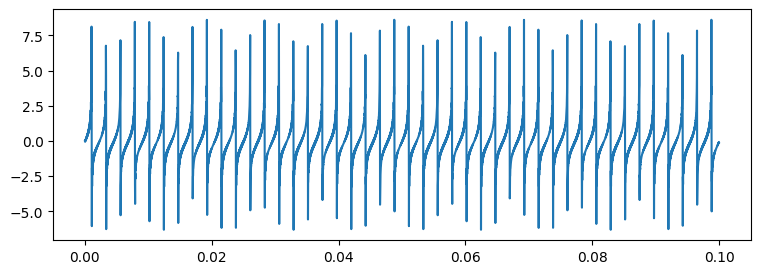

In [8]:
plt.figure(figsize=(9, 3))
plt.plot(x, wave)
Audio(wave, rate=sampling.rate)

In [9]:
# FFT definition
fft_config = FFTConfig(
    size=256,
    cutoff=220.0, # below our base frequency 440 Hz
    log_even_components=64, 
)

In [10]:
# FFT calculation
spectrum: Histogram = calculate_spectrum(wave, fft_config, sampling)
bands: np.ndarray = spectrum.edges
log_even_bands: np.ndarray = to_log_even_bands(bands, fft_config)
log_even_spectrum: Histogram = spectrum.rebin(log_even_bands)

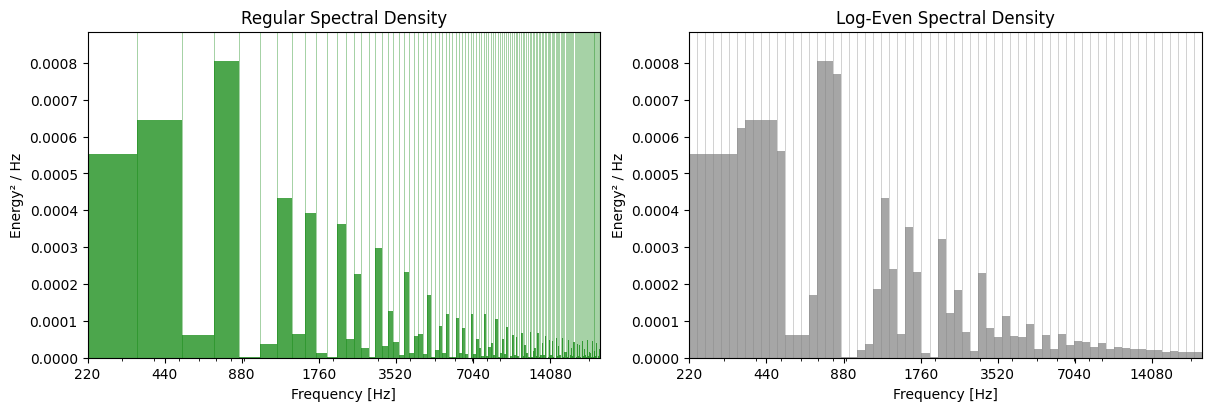

In [11]:
# Spectrum and a rebinned spectrum
compare_spectra(
    spectra=(spectrum, log_even_spectrum),
    sample_rate=sampling.rate,
    cutoff=fft_config.cutoff,
    titles=("Regular Spectral Density", "Log-Even Spectral Density"),
    colors=("green", "gray"),
)

We can see that for a small DFT of a size $256$ we cannot distinguish properly lower tones, including our base frequency $440$ Hz. That information is lost and cannot be restored through the energy-preserving frequency rebinning.

## Constant-Q Transform

The **Constant-Q Transform (CQT)** is an alternative frequency decomposition method that directly produces logarithmically-spaced frequency bins. The name comes from the constant **Q factor**, which is the ratio of center frequency to bandwidth—this ratio remains the same for all bins in the CQT.

While the DFT produces bins at frequencies $f_k = k \cdot \frac{f_{\text{sr}}}{N}$ for $k = 0, 1, \ldots, N-1$, the CQT generates bins at $f_k = f_{\min} \cdot 2^{k/b}$, where $b$ is the number of bins per octave. This means each octave (frequency doubling) contains the same number of bins. This aligns with musical pitch perception.

The main advantage of CQT is clear: it provides the logarithmic frequency distribution without any necessity of rebinning operation. However, computing the CQT is just more expensive than the FFT-based DFT, as no fast algorithm analogous to the FFT exists for the CQT. What is worth pointing out, is that CQT has non-uniform time resolution: higher frequencies are analyzed with shorter windows.

Let us compare the CQT spectrum with our rebinned log-even spectrum to see how they differ in practice.

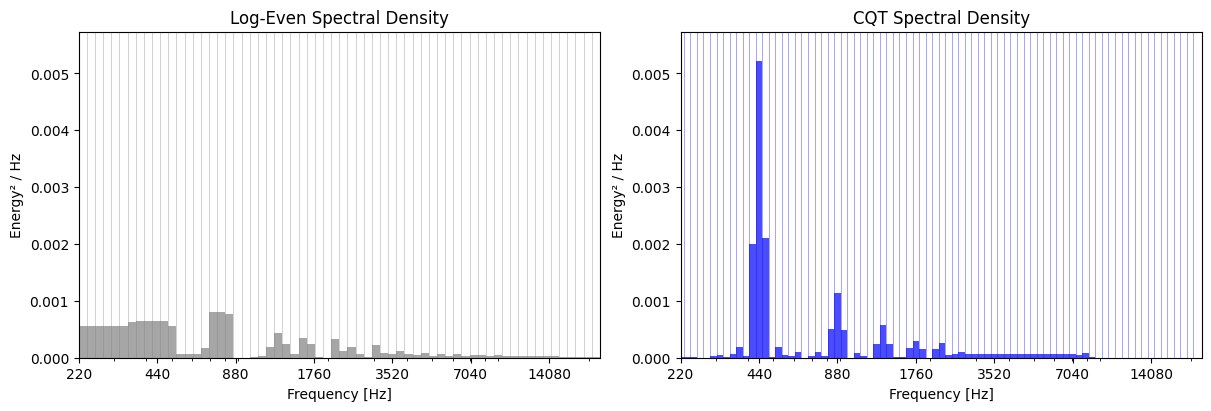

In [12]:
cqt_spectrum = calculate_cqt_spectrum(wave, fft_config, sampling)
compare_spectra(
    spectra=(log_even_spectrum, cqt_spectrum),
    sample_rate=sampling.rate,
    cutoff=fft_config.cutoff,
    titles=("Log-Even Spectral Density", "CQT Spectral Density"),
    colors=("gray", "blue"),
)

We can easily observe that CQT has no problems with recognizing a fundamental tone, for which log-even spectral density. This is because the original DFT struggled to discern lower frequencies.

Now let us increase the size of DFT to a proper, decent number of items ($4096$).

In [13]:
# FFT definition
fft_config = FFTConfig(
    size = 4096,  # this time we increase FFT size
    cutoff = 220.0,
    log_even_components = 80,  # there are 80 musical notes spanning from 220 to 22050 Hz
)

In [14]:
# Spectrum, log-even spectrum and CQT
spectrum = calculate_spectrum(wave, fft_config, sampling)
log_even_bands = to_log_even_bands(bands, fft_config)
log_even_spectrum = spectrum.rebin(log_even_bands)
cqt_spectrum = calculate_cqt_spectrum(wave, fft_config, sampling)

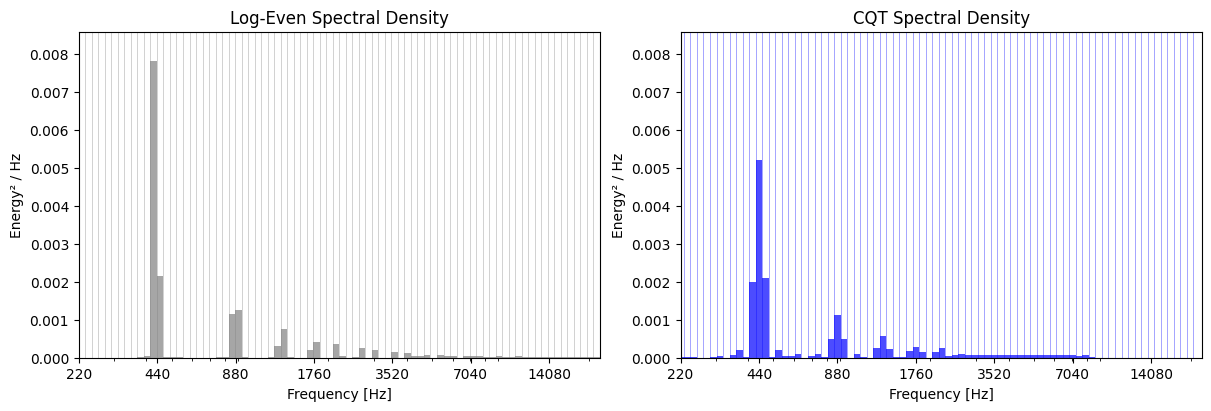

In [15]:
# Comparison
compare_spectra(
    spectra=(log_even_spectrum, cqt_spectrum),
    sample_rate=sampling.rate,
    cutoff=fft_config.cutoff,
    titles=("Log-Even Spectral Density", "CQT Spectral Density"),
    colors=("gray", "blue"),
)

The results are now comparable

CQT supports a spectrogram out of the box, so we can use it directly to see how these frequencies change over time.

## Interactive example

You can play around with different settings to see how these three spectra compare to each other.

Pay attention that the log-even spectrum is dependent on the regular one.

In [16]:
%matplotlib inline
interactive_example(wave_definition)

Output()

interactive(children=(SelectionSlider(description='Sample Rate (Hz):', index=3, layout=Layout(width='600px'), …